## Network Analysis
User rating businesses can be viewed as a correlation network of these businesses based user-rated stars. In this network analysis, we aimed to find the most highly-correlated businesses based on the network structure of the businesses. The star ranking takes values ranging between 1 - 5. When the star-ranking is positively correlated between two businesses, they are connected with a red edge in the business network. When the star-ranking is negatively correlated between two businesses, they are connected with a blue edge. We used Spearman's ranked correlation analysis. We included the following businesses:
- Restaurants and bars in Las Vegas
- Restaurants and bars in Phoenix

In [1]:
from load_yelp_data import load_yelp_dataframe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
%matplotlib inline
import networkx as nx
import random
import scipy.stats

In [4]:
#Load data
businesses = load_yelp_dataframe('businesses').drop('Unnamed: 0', 1)
reviews = load_yelp_dataframe('reviews').drop('Unnamed: 0', 1)
users = load_yelp_dataframe('users').drop('Unnamed: 0', 1)

#Classify the datapoints into the cities based on the latitude and the longitude
cities = np.array([['Edinburgh', 55.9533, -3.1883, 0, 0],
         ['Karlsruhe', 49.0069, 8.4037, 0, 0],
         ['Montreal', 45.5017, -73.5673, 0, 0],
         ['Waterloo', 43.4643, -80.5204, 0, 0],
         ['Pittsburgh', 40.4406, -79.9959, 0, 0],
         ['Charlotte', 35.2271, -80.8431, 0, 0],
         ['Urbana-Champaign', 40.1106, -88.2073, 0, -150000],
         ['Phoenix', 33.4484, -112.0740, 0, 0],
         ['Las Vegas', 36.1699, -115.1398, 0, 0],
         ['Madison', 43.0731, -89.4012, 0, 0]])
lat = np.array(cities[:,1], np.float32)
lon = np.array(cities[:,2], np.float32)
x_offsets = np.array(cities[:,3], np.float32)
y_offsets = np.array(cities[:,4], np.float32)

def classify_datapoint_by_latitude_and_longitude(datapoint):
#     print datapoint
    latitude = datapoint['latitude']
    longitude = datapoint['longitude']
    distances = (latitude - lat)**2 + (longitude - lon)**2
    min_dist = np.argmin(distances)
    return cities[min_dist, 0]

businesses['location'] = businesses.apply(classify_datapoint_by_latitude_and_longitude, axis=1)

In [5]:
##Due to the memory error, first select cities and restaurants
#Choose Las Vegas and Phoenix only
businesses_2cities = businesses[ (businesses['location'] == 'Phoenix') | (businesses['location'] == 'Las Vegas') ]

#Select restaurants
is_restaurants = []
for i in range(0, businesses_2cities.shape[0]):
    if "Restaurants" in businesses_2cities.iloc[i, 2]:
        is_restaurants.append(True)
    elif "Bars" in businesses_2cities.iloc[i, 2]:
        is_restaurants.append(True)
    else:
        is_restaurants.append(False)

restaurants = businesses_2cities[is_restaurants]

In [6]:
##Clean and merge businesses data with reviews data
#Rename duplicated column names between businesses and reviews datasets
restaurants = restaurants.rename(columns = {'stars': 'stars_business'})

#Merge with the reviews dataset
restaurants_reviews = reviews.merge(restaurants, how='inner', on='business_id') 

#When users reviewed a business more than once, take the most updated review result
restaurants_reviews = restaurants_reviews.sort_values(by=['year', 'month', 'day'], ascending=True, axis=0)
restaurants_reviews_nodup = restaurants_reviews.drop_duplicates(subset=('user_id', 'business_id'), keep='last')

Now, we split the data into train and test sets and constructed a network in the train set. Here we further prepared the data to obtain a correlation matrix. We only included top 100 frequently-reviewed restaurants and bars to know if the user reviews in training set can predict the rating of businesses in the testing set.

In [45]:
##Create Las Vegas and Phoenix data##
#Due to memory error, top 100 restraurants were chosen to do predictions
LVrestaurants = restaurants_reviews_nodup[ restaurants_reviews_nodup['location'] == 'Las Vegas' ]
PHrestaurants = restaurants_reviews_nodup[ restaurants_reviews_nodup['location'] == 'Phoenix' ]

#Create train and test sets
#Output: correlation matrix and top100 business_ids in each column for train and test sets
def train_and_test(df):
    #Slect top 100 frequently rated restaurants
    df100count = df['business_id'].value_counts()[:100]
    df100id = df100count.index
    mask = df['business_id'].isin(df100id)
    df100 = df[mask]

    n, m = df100.shape
    train = df100.sample(n=int(0.7*n), replace=False, random_state=1000)
    test = df100.drop(train.index)
    
    #Drop unnecessary variables
    train2 = train[['user_id', 'business_id', 'stars']]
    test2 = test[['user_id', 'business_id', 'stars']]
    
    #Create correlation matrix of star rating for train and test sets
    train_t = train2.pivot(index='user_id', columns='business_id', values='stars')
    train_corr_matrix = train_t.corr(method='spearman')
    #train_corr_matrix_values = train_corr_matrix.reset_index().values

    test_t = test2.pivot(index='user_id', columns='business_id', values='stars')
    test_corr_matrix = test_t.corr(method='spearman')
    #test_corr_matrix_values = test_corr_matrix.reset_index().values
    
    return train_corr_matrix, train, test_corr_matrix, test

LV_train, LV_train100, LV_test, LV_test100 = train_and_test(LVrestaurants)
PH_train, PH_train100, PH_test, PH_test100 = train_and_test(PHrestaurants)

## Construct a network in the training set for Las Vegas

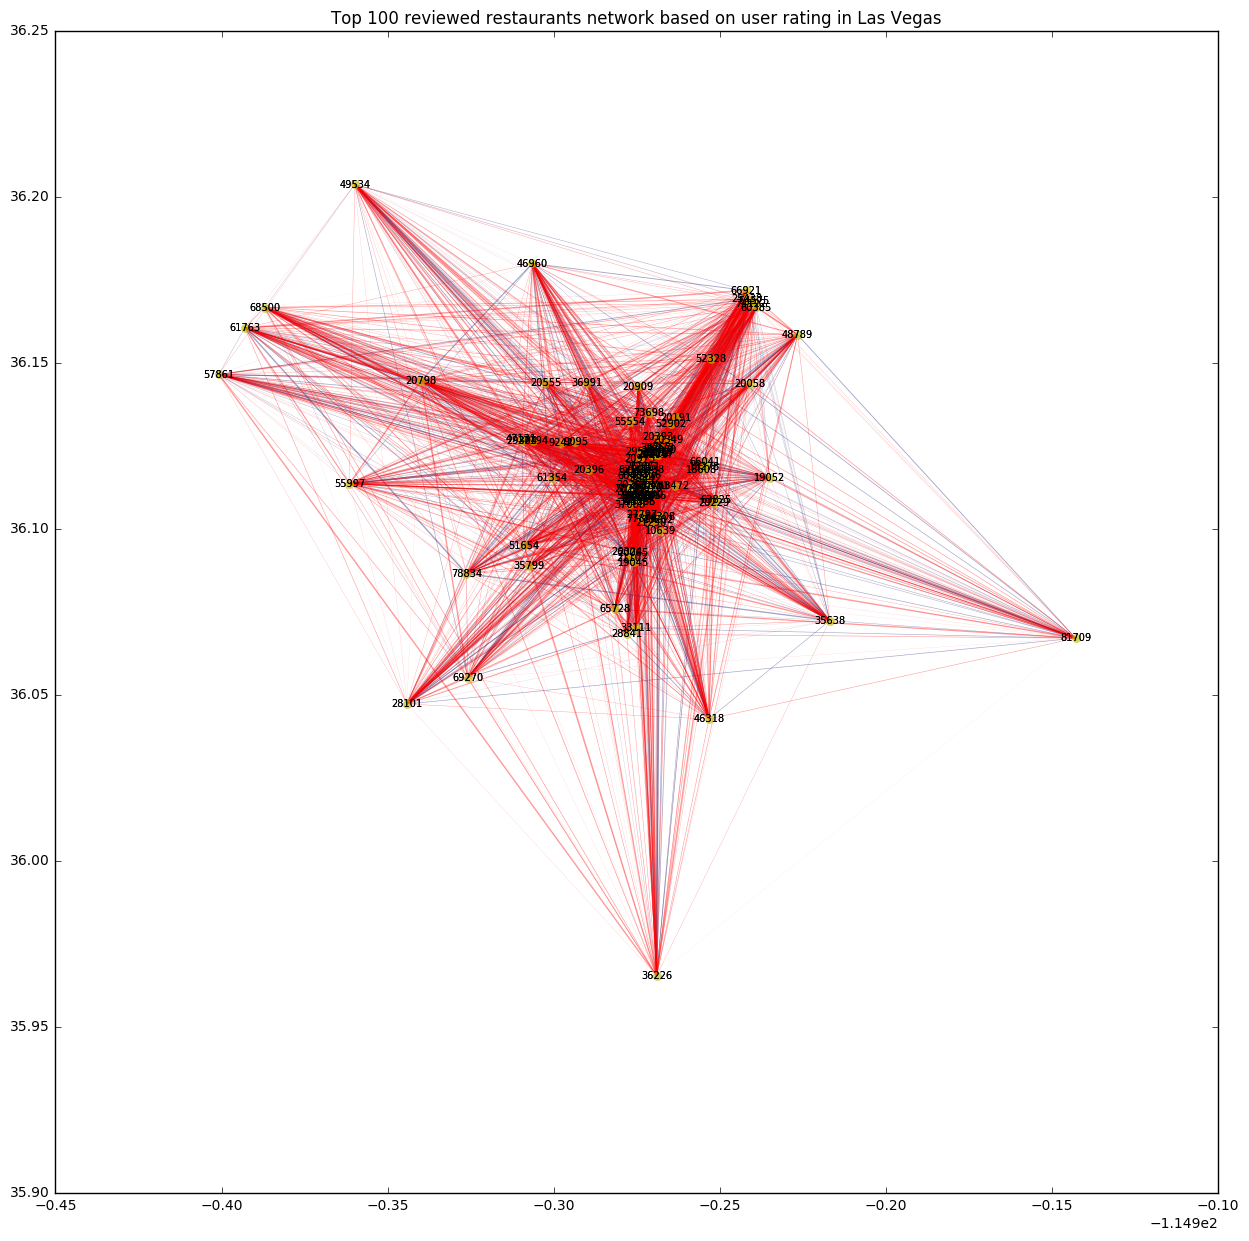

In [37]:
##Construct Las Vegas network using top 100 reviewed restaurants in the train set
#Create position for the network
posx = []
for i in range(0, LV_train100.shape[0]):
    posx.append((LV_train100.iloc[i, 1], [LV_train100.iloc[i, 12], LV_train100.iloc[i, 11]]))#business id, longitude, latitude

position_dic = dict(posx)

node0=[]
node1=[]
weight0=[]
weight1=[]
columns=LV_train.columns.values
LVcorr_matrix_values = LV_train.reset_index().values
for i, line in enumerate(LVcorr_matrix_values):
    tokens=LVcorr_matrix_values[i]
    row=tokens[0]
    for column, cell in zip(columns[i:],tokens[i+1:]):
        if (cell != "") and (float(cell) < 0):
            node0.append(( int(row), int(column) ))
            weight0.append(float(cell))
        elif (cell != "") and (float(cell) > 0):
            node1.append(( int(row), int(column) ))
            weight1.append(float(cell))

#remove self-edge
node1 = [x for x in node1 if x[0] != x[1]]
            
G0=nx.Graph()
G0.add_nodes_from(columns)
G0.add_edges_from(node0)
G1=nx.Graph()
G1.add_nodes_from(columns)
G1.add_edges_from(node1)

weight0x=[i for i in weight0]
weight1x=[i*(-1) for i in weight1]

plt.figure(figsize=(15, 15))
plt.title('Top 100 reviewed restaurants network based on user rating in Las Vegas')
nx.draw_networkx(G0, position_dic, width=weight0x, edge_color='midnightblue', node_color='y', node_size=40, linewidths=0, alpha=0.4, font_size=7)
nx.draw_networkx(G1, position_dic, width=weight1x, edge_color='r',            node_color='y', node_size=40, linewidths=0, alpha=0.4, font_size=7)
plt.show()

In the above network graph, a node represents business id, x axis is longitude, and y axis is latitude of the actual location of restraurants and bars. Red lines show positive correlation between businesses and blue lines are negative correlation, based on user-rated stars. The graph shows that most of the businesses are centered together and some businesses are located in the peripheral. We'll now exmine some network characteristics.

Number of nodes: 100
Number of total edges: 4678
Median degree: 95.0


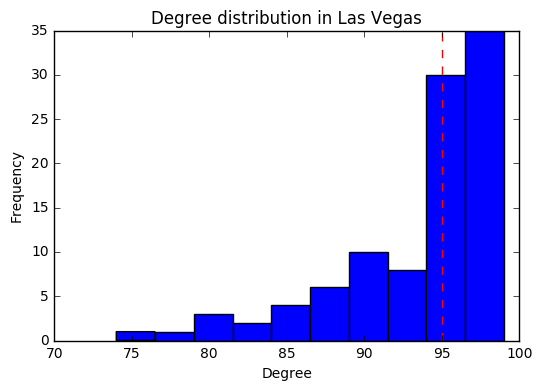

In [38]:
##Network characteristics
# Negative and positive network combined
G01=nx.Graph()
G01.add_nodes_from(columns)
node=[]
node=list(node0 + node1)
weight=list(weight0 + weight1)
G01.add_edges_from(node)

#Number of nodes
print 'Number of nodes:', len(G01.nodes())

#Number of edges
print 'Number of total edges:', len(G01.edges()) 

#Median degree
median_degree_LV = np.median(G01.degree().values())
print 'Median degree:', median_degree_LV

#Degree distribution
plt.title('Degree distribution in Las Vegas')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.hist(G01.degree().values())
plt.axvline(median_degree_LV, color='r', linestyle='dashed', linewidth=1)
plt.show()

The above analysis and figure show that we have 100 businesses and the median value of the degree (i.e., how many connections a business has) was 95, and most businesses are highly connected with each other. Now, we use the PageRank algorithm to infer user-liked restaurants based on this network structure. The PageRank returns the percentage of "relevance" (here it is the relevance to higher stars) using the connectivity structure. Then, we asigne stars (1 to 5) using this probability to be liked by users, based on the star ditribution structure in the traning set.

In [39]:
##Rank all businesses using PageRank and weight

pr = nx.pagerank(G01, weight='weight') #pr is dictionary. All values sum up to 1
#sum(pr.values()) returns 1

#Convert percentage to 1-5 values based on the star distribution percentile (5 star is above 43 percentile)
for x, y in pr.items():
    if pr[x] >= np.percentile( pr.values(), float(LV_train100['stars'].value_counts()[:1] / LV_train100.shape[0])*100 ): 
        pr[x] = 5 
    elif pr[x] >= np.percentile( pr.values(), float(LV_train100['stars'].value_counts()[1:2] / LV_train100.shape[0])*100 ): 
        pr[x] = 4
    elif pr[x] >= np.percentile( pr.values(), float(LV_train100['stars'].value_counts()[2:3] / LV_train100.shape[0])*100 ): 
        pr[x] = 3
    elif pr[x] >= np.percentile( pr.values(), float(LV_train100['stars'].value_counts()[3:4] / LV_train100.shape[0])*100 ): 
        pr[x] = 2
    else:
        pr[x] = 1


## Testing set for Las Vegas
Now, we compare the estimated stars with the actual stars in the testing set that also include top 100 restaurants and bars in Las Vegas.

In [40]:
pred_LV = []
for i in LV_test100['business_id']:
    pred_LV.append(pr[i])

stars_LV = LV_test100['stars']

N = LV_test100.shape[0]
RSS = np.sum( (pred_LV - stars_LV)**2 )
RSE = np.sqrt( RSS / (N-2))

print "Average deviation of the response from the true value, RSE", RSE

Average deviation of the response from the true value, RSE 1.73205080757


This analysis included 100 businesses located in Las Vegas. The node in the network figure indicates a business ID, and an edge represents a connection between businesses. The correlation coefficients were calcuated using Spearman's ranked correlation analysis. The red color indicates positive correlation, and the blue color is negative correlation between businesses. Using PageRank algorithm of this network model (https://en.wikipedia.org/wiki/PageRank), we predicted the importance of businesses in the test set and assigned stars based on the star distribution (i.e., porportional to the observed star counts in the train set). This results shows that the RSE was 1.7, indicating that this model would not perform so well compared with the other models we tested. In the next step, we apply this method to businesses in phoenix.

## Construct a network in the training set for Phoenix

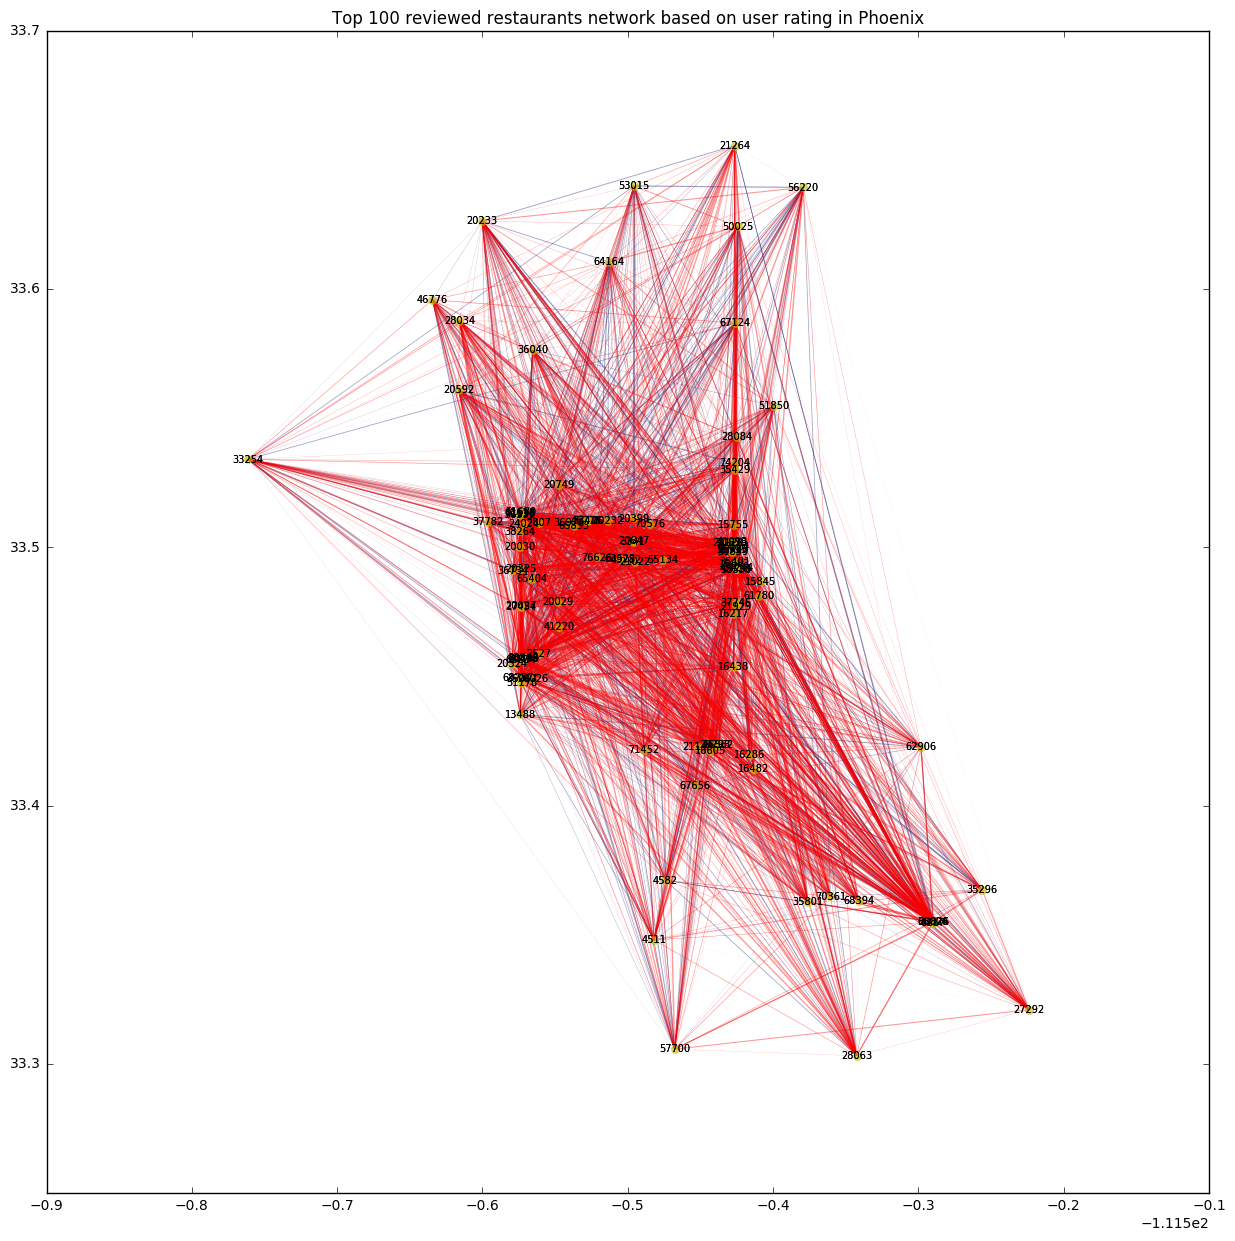

In [46]:
##Construct Phoenix network using top 100 reviewed restaurants in the train set
#Create position for the network
posx = []
for i in range(0, PH_train100.shape[0]):
    posx.append((PH_train100.iloc[i, 1], [PH_train100.iloc[i, 12], PH_train100.iloc[i, 11]]))#business id, longitude, latitude

position_dic = dict(posx)

node0=[]
node1=[]
weight0=[]
weight1=[]
columns=PH_train.columns.values
PHcorr_matrix_values = PH_train.reset_index().values
for i, line in enumerate(PHcorr_matrix_values):
    tokens=PHcorr_matrix_values[i]
    row=tokens[0]
    for column, cell in zip(columns[i:],tokens[i+1:]):
        if (cell != "") and (float(cell) < 0):
            node0.append(( int(row), int(column) ))
            weight0.append(float(cell))
        elif (cell != "") and (float(cell) > 0):
            node1.append(( int(row), int(column) ))
            weight1.append(float(cell))

#remove self-edge
node1 = [x for x in node1 if x[0] != x[1]]
            
G0=nx.Graph()
G0.add_nodes_from(columns)
G0.add_edges_from(node0)
G1=nx.Graph()
G1.add_nodes_from(columns)
G1.add_edges_from(node1)

weight0x=[i for i in weight0]
weight1x=[i*(-1) for i in weight1]

plt.figure(figsize=(15, 15))
plt.title('Top 100 reviewed restaurants network based on user rating in Phoenix')
nx.draw_networkx(G0, position_dic, width=weight0x, edge_color='midnightblue', node_color='y', node_size=40, linewidths=0, alpha=0.4, font_size=7)
nx.draw_networkx(G1, position_dic, width=weight1x, edge_color='r',            node_color='y', node_size=40, linewidths=0, alpha=0.4, font_size=7)
plt.show()

Businesses in Phoenix are more widely located in the city. At appearance, there are more bule edges in this network, compared with the network in Las Vegas, indicating that more reviews include lower ratings in Phoenix. Again, businesses are highly connected even in the businesses in the peripheral of the city.

Number of nodes: 100
Number of total edges: 4506
Median degree: 92.0


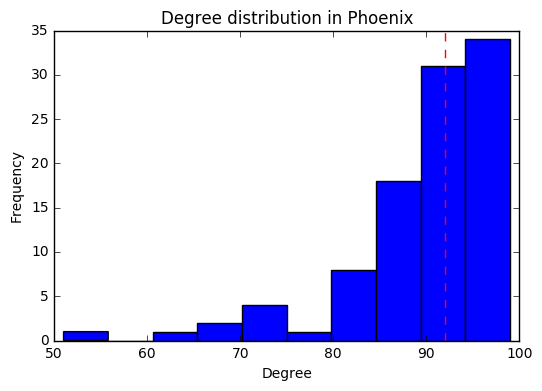

In [47]:
##Network characteristics
# Negative and positive network combined
G01=nx.Graph()
G01.add_nodes_from(columns)
node=[]
node=list(node0 + node1)
weight=list(weight0 + weight1)
G01.add_edges_from(node)

#Number of nodes
print 'Number of nodes:', len(G01.nodes())

#Number of edges
print 'Number of total edges:', len(G01.edges()) 

#Median degree
median_degree_LV = np.median(G01.degree().values())
print 'Median degree:', median_degree_LV

#Degree distribution
plt.title('Degree distribution in Phoenix')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.hist(G01.degree().values())
plt.axvline(median_degree_LV, color='r', linestyle='dashed', linewidth=1)
plt.show()

In the degree distribution figure, we see that a small number of businesse are highly rated but not so connected with other businessses (businesses with degree less than 60), and most of the businesses are correlated.

In [48]:
##Rank all businesses using PageRank and weight

pr = nx.pagerank(G01)

#Convert percentage to 1-5 values based on the star distribution percentile (
for x, y in pr.items():
    if pr[x] >= np.percentile( pr.values(), float(PH_train100['stars'].value_counts()[:1] / PH_train100.shape[0])*100 ): 
        pr[x] = 5 
    elif pr[x] >= np.percentile( pr.values(), float(PH_train100['stars'].value_counts()[1:2] / PH_train100.shape[0])*100 ): 
        pr[x] = 4
    elif pr[x] >= np.percentile( pr.values(), float(PH_train100['stars'].value_counts()[2:3] / PH_train100.shape[0])*100 ): 
        pr[x] = 3
    elif pr[x] >= np.percentile( pr.values(), float(PH_train100['stars'].value_counts()[3:4] / PH_train100.shape[0])*100 ): 
        pr[x] = 2
    else:
        pr[x] = 1


In [49]:
pred_PH = []
for i in PH_test100['business_id']:
    pred_PH.append(pr[i])

stars_PH = PH_test100['stars']

N = PH_test100.shape[0]
RSS = np.sum( (pred_PH - stars_PH)**2 )
RSE = np.sqrt( RSS / (N-2))

print "Average deviation of the response from the true value, RSE", RSE

Average deviation of the response from the true value, RSE 1.73205080757


In summary, the network-based analysis uses the ranking approach to find favorable restaurants in the training set and predict stars in the testing set. In this baseline model, RSE was > 1.7, indicating that the method needs to be improved to further have better ability of predicting user-rated stars in the testing datasets by estimating and assigning stars more precisely.